<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span><ul class="toc-item"><li><span><a href="#Признаки" data-toc-modified-id="Признаки-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Признаки</a></span></li><li><span><a href="#Целевой-признак" data-toc-modified-id="Целевой-признак-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Целевой признак</a></span></li></ul></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных-выводы" data-toc-modified-id="Подготовка-данных-выводы-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовка данных выводы</a></span></li></ul></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Описание данных

### Признаки 
• RowNumber — индекс строки в данных <br>
• CustomerId — уникальный идентификатор клиента <br>
• Surname — фамилия<br>
• CreditScore — кредитный рейтинг<br>
• Geography — страна проживания<br>
• Gender — пол<br>
• Age — возраст<br>
• Tenure — сколько лет человек является клиентом банка<br>
• Balance — баланс на счёте<br>
• NumOfProducts — количество продуктов банка, используемых клиентом<br>
• HasCrCard — наличие кредитной карты<br>
• IsActiveMember — активность клиента<br>
• EstimatedSalary — предполагаемая зарплата<br>

### Целевой признак
Exited — факт ухода клиента

## Подготовка данных

In [1]:
!python3 -m venv venv
!source venv/bin/activate
!pip install -r requirements.txt -q

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [5]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv').drop(columns = ['RowNumber'])
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Вообще говоря ни Surname, ни CustomerId не несут никаких данных об объекте, а нужны лишь для наименования объектов. Поэтому при дальнейшем анализе их стоит исключить. Единственное, что стоит проверить, что у нас одному CustomerId соответствует ровно один объект. Для этого сгруппируем по CustomerId, подсчитаем количество объектов для каждого CustomerId и возьмем среднее. 

In [4]:
data.groupby(by = 'CustomerId').agg({'Gender': 'count'}).mean()

Gender    1.0
dtype: float64

Действительно, каждому CustomerId соответствует один объект. 

In [5]:
data = data.drop(columns = ['CustomerId', 'Surname'])
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Изучим наличие пропусков в данных 

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Мы имеем 909 пропусков в графе Tenure (сколько лет человек является клиентом банка). 

Как мы можем поступить с этими пропусками?

1. Выяснить причины пропусков и закрыть на основании данных причин (выходит за рамки данной задачи, по имеющимся данным установить достоверно причины невозможно). <em> В дальнейшем будет показано, что проблема может быть в том, что в поле Tenure невозможно внести числа большие 10 и часть людей оставляет это поле пустым или вводит 10. </em>
2. Удалить строки с пропусками (в силу относительно небольшого числа пропусков это можно сделать). Но таким образом мы потеряем часть данных
3. Заменить средним/медианой по всей выборке или с учетом структуры данных (например, если бы у нас был датасет с зарплатами сотрудников и категориями специалист/менеджер/топменеджер, у которых зарплаты существенно отличаются, и были бы пропуски в графе "зарплаты", то логично было бы заменять средней/медианой по конкретной категории). Такой способ неплохо подходит для анализа зависимостей в данных, но может ухудшить качество модели

Реализуем пункт 2

In [7]:
data.dropna(inplace = True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      9091 non-null   int64  
 1   Geography        9091 non-null   object 
 2   Gender           9091 non-null   object 
 3   Age              9091 non-null   int64  
 4   Tenure           9091 non-null   float64
 5   Balance          9091 non-null   float64
 6   NumOfProducts    9091 non-null   int64  
 7   HasCrCard        9091 non-null   int64  
 8   IsActiveMember   9091 non-null   int64  
 9   EstimatedSalary  9091 non-null   float64
 10  Exited           9091 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 852.3+ KB


Посмотрим на наши признаки более подробно. У нас есть числовые признаки CreditScore, Age, Tenure, Balance, NumOfProducts, EstimatedSalary, категориальные признаки Geography, Gender, HasCrCard, IsActiveMember

In [9]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Подробнее изучим распределение категориальных и числовых признаков, а также посмотрим, насколько сбалансирован таргет.

In [10]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CreditScore,9091.0,NaN,NaN,NaN,650.736553,96.410471,350.0,584.0,652.0,717.0,850.0
Geography,9091,3,France,4550,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,9091,2,Male,4974,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,9091.0,NaN,NaN,NaN,38.949181,10.555581,18.0,32.0,37.0,44.0,92.0
Tenure,9091.0,NaN,NaN,NaN,4.99769,2.894723,0.0,2.0,5.0,7.0,10.0
Balance,9091.0,NaN,NaN,NaN,76522.740015,62329.528576,0.0,0.0,97318.25,127561.89,250898.09
NumOfProducts,9091.0,NaN,NaN,NaN,1.530195,0.581003,1.0,1.0,1.0,2.0,4.0
HasCrCard,9091.0,NaN,NaN,NaN,0.704983,0.456076,0.0,0.0,1.0,1.0,1.0
IsActiveMember,9091.0,NaN,NaN,NaN,0.515565,0.499785,0.0,0.0,1.0,1.0,1.0
EstimatedSalary,9091.0,NaN,NaN,NaN,100181.214924,57624.755647,11.58,51227.745,100240.2,149567.21,199992.48


Мы имеем существенно несбалансированный таргет (почти в 4 раза)

In [11]:
data['Geography'].value_counts(normalize = True)

France     0.500495
Germany    0.252227
Spain      0.247278
Name: Geography, dtype: float64

In [12]:
data['HasCrCard'].value_counts(normalize = True)

1    0.704983
0    0.295017
Name: HasCrCard, dtype: float64

In [13]:
data['IsActiveMember'].value_counts(normalize = True)

1    0.515565
0    0.484435
Name: IsActiveMember, dtype: float64

Посмoтрим за распределением признаков с разным значением таргета

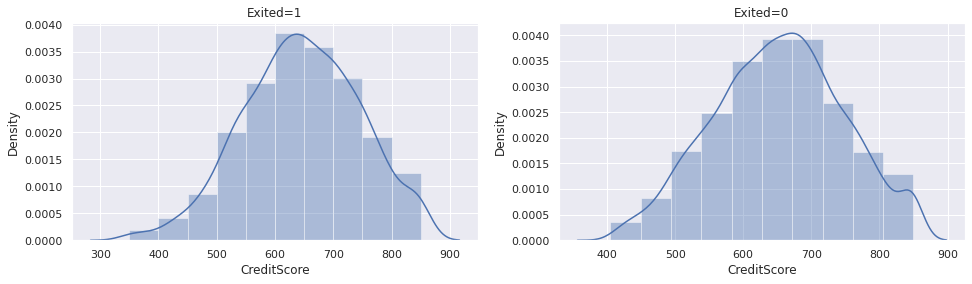

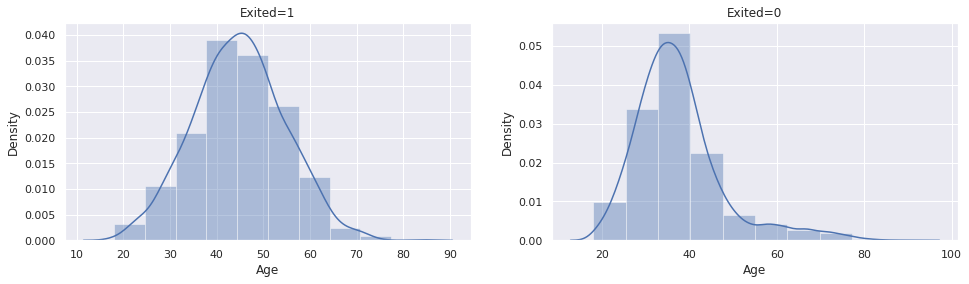

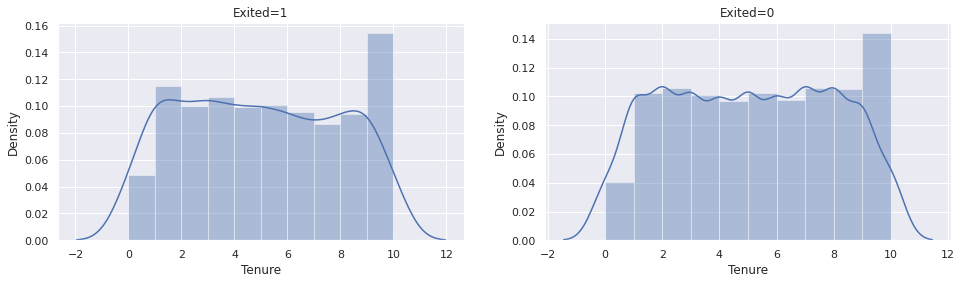

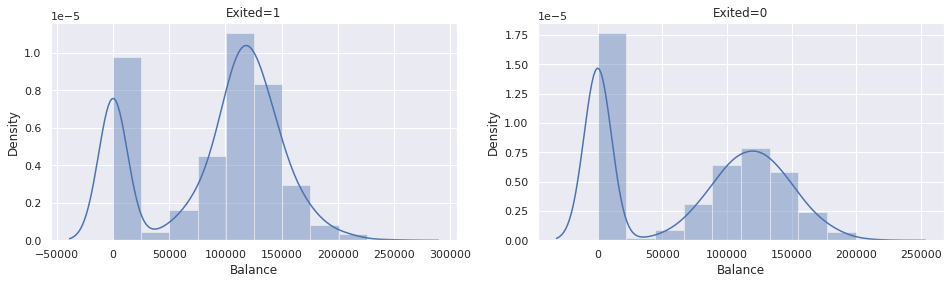

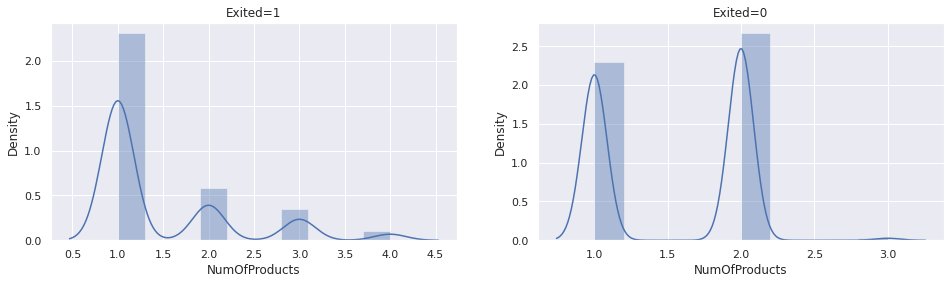

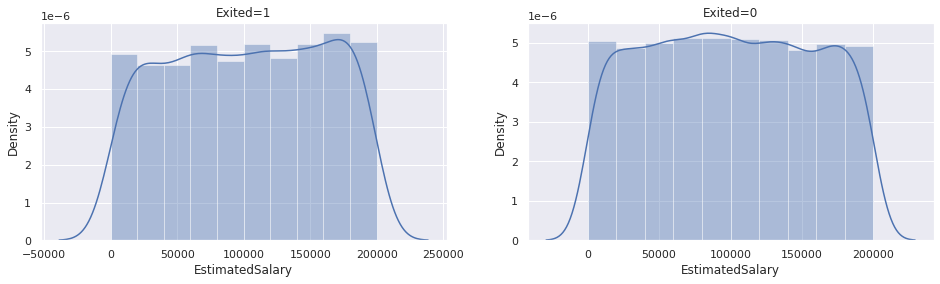

In [14]:
#числовые
sns.set(rc={'figure.figsize':(16, 4)})
sns.set_style("darkgrid")
for column in numeric:
    plt.subplot(1, 2, 1)
    sns.distplot(data.query('Exited == 1')[column], bins=10).set(title='Exited=1')
    plt.subplot(1, 2, 2)
    sns.distplot(data.query('Exited == 0')[column], bins=10).set(title='Exited=0')
    plt.show()

Очень заметен выброс в Balance в сторону нуля. Возможно, довольно заметная часть клиентов не хранит деньги на счетах вообще. Или по ним не было данных и пропуски закрывались нулём. Также заметно аномально большое число клиентов, которые пользуются услугами банка 10 лет и странно, что график обрывается: то есть имеется много клиентов, кто пользуется 10 лет, но нет клиентов, которые бы пользовались, например, 11 лет. Было бы интересно посмотреть на форму анкеты, с которой собирались эти данные: возможно, старые пользователи (больше 10 лет) просто ставят срок пользования услугами банка 10 лет, не имея возможности поставить бОльший срок.   

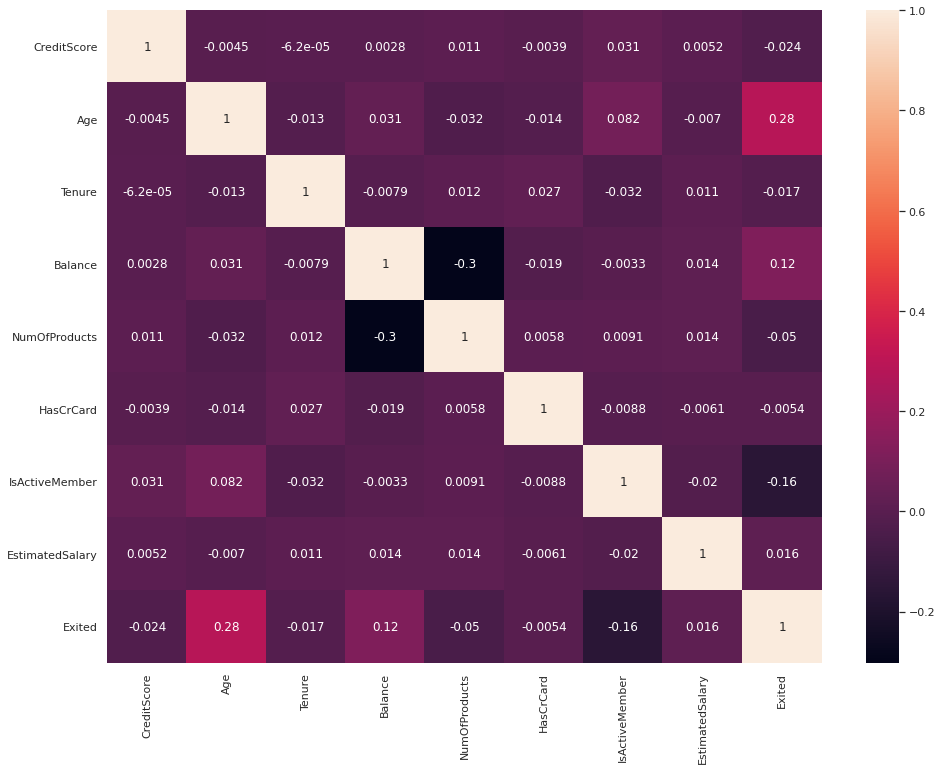

In [15]:
sns.set(rc={'figure.figsize':(16, 12)})
sns.heatmap(data.corr(), annot=True)
plt.show()

### Подготовка данных выводы

1. Произведен первичный анализ данных, удалены 909 строк (из 10 000) с пропусками в графе Tenure
2. Таргет существенно несбалансирован в сторону нуля (почти в 4 раза)
3. Обнаружены выбросы в графе Balance (аномально большое число пользователей с нулевым балансом)
4. Обнаружены выбросы в графе Tenure (большое число пользователей, которые пользуются услугами банка 10 лет, причем график резко обрывается). 
5. Заметной корреляции между признаками и целевой переменной не обнаружено.

## Исследование задачи


Сначала будем искать оптимальную модель без учета баланса классов. Будем использовать логистическую регрессию и RandomForestClassifier. У нас есть как категориальные, так числовые признаки. Категориальные признаки закодируем с помощью one hot encoding. Будем измерять метрики f1 и AUC ROC. </div>

In [16]:
data_ohe = pd.get_dummies(data, drop_first=True)
features = data_ohe.drop(columns = ['Exited'])
target = data_ohe['Exited']

Разделим выборку на три части: обучающая (для обучения модели, 60%), валидационную (для подбора гиперпараметров, 20%) и тестовую (для оценки качества модели).

In [17]:
features_1, features_test, target_1, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345)

#доля выросла до 25%, так как ранее мы уже отрезали 20% от выборки на тест
features_train, features_valid, target_train, target_valid = train_test_split(
    features_1, target_1, test_size=0.25, random_state=12345)

#проверим размеры выборок
for item in [features_train, features_valid, features_test]:
    print(round(item.shape[0]*100/features.shape[0], 2),'%')

59.99 %
20.0 %
20.01 %


Отмасштабируем числовые признаки

In [18]:
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

При выборе метрик нам необходимо подумать о том, зачем мы вообще строим прогнозную модель. <br>
1. Если мы хотим найти максимальное количество клиентов, которые собираются уйти (чтобы вручить им тот или иной подарок, чтобы они остались), пусть и ценой того, что в найденных клиентах будет много лояльных клиентов (для которых этот подарок - пустая трата средств в плане удержания), то нам надо максимизировать Recall (то есть количество клиентов, которых модель назвала нелояльными и которые действительно собираются уйти, поделить на всех клиентов, которые собираются уйти). <b> То есть подарок для клиента стоит дешево, а сам клиент стоит дорого (оставшийся ltv). </b> Но надо быть готовым к тому, что максимизировать Recall всегда будет тривиальная модель, которая тегирует всех клиентов как нелояльные.<br>
2. Модель находит нам некоторое количество нелояльных клиентов. Если мы хотим, чтобы доля действительно нелояльных клиентов в этом наборе была максимальна, то нам надо максимизировать Precision (то есть количество клиентов, которых модель назвала нелояльными и которые действительно собираются уйти, поделить на общее число клиентов, помеченных системой как нелояльные). Но в этом случае, мы рискуем оставить за бортом большое число нелояльных клиентов и потерять их. Зато <b> при максимизации Precision мы будем вручать подарки тем клиентам, в чьей нелояльности мы уверены. Подарок стоит сравнимо с оставшимся ltv этого клиента. </b>
</div>

Также проверим модели на адекватность: добавим качество константной модели. 


"Обучим" константную модель и измерим метрики.

In [19]:
target_pred_constant = pd.Series([0]*len(target_valid))
print('Значение f1 метрики и ROC AUC равно', 
      f1_score(target_valid, target_pred_constant), ',', roc_auc_score(target_valid, target_pred_constant))

Значение f1 метрики и ROC AUC равно 0.0 , 0.5


Обучим логистическую регрессию и случайный лес и измерим метрики. Так как мы это будем в дальнейшем делать несколько раз, напишем функцию. 

In [20]:
def test_logrec_rforest(features_train, target_train, depth_range, est_range, cl_weight = None):
    model = LogisticRegression(random_state = 12345, solver = 'liblinear', class_weight = cl_weight)
    model.fit(features_train, target_train)
    probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
    
    score_dict = {}
    for threshold in np.arange(0, 0.99, 0.01):
        predicted_valid = [1 if item>=threshold else 0 for item in probabilities_one_valid]
        score_dict[threshold] = [f1_score(target_valid, predicted_valid), roc_auc_score(target_valid, predicted_valid)]
    
    print('Максимальное значение f1 меры на валидационной выборе для логистической регрессии равно',
          f'{score_dict[sorted(score_dict, key = lambda x: -score_dict[x][0])[0]][0]:.3f},',
          'соответствующее значение AUC ROC равно',
          f'{score_dict[sorted(score_dict, key = lambda x: -score_dict[x][0])[0]][1]:.3f}')
    
    score_dict = {}
    for depth in depth_range:
        for est in est_range:
            model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state = 12345, class_weight = cl_weight)
            model.fit(features_train, target_train)
            predicted_valid = model.predict(features_valid)
            f1 = f1_score(target_valid, predicted_valid)
            
            probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
            sd = {}
            for threshold in np.arange(0, 0.99, 0.01):
                predicted_valid = [1 if item>=threshold else 0 for item in probabilities_one_valid]
                sd[threshold] = roc_auc_score(target_valid, predicted_valid)
                
            auc_roc = sd[sorted(sd, key = lambda x: -sd[x])[0]]
            score_dict[(depth, est)] = [f1, auc_roc]
            
    print('Максимальное значение f1 меры на валидационной выборе для случайного леса равно',
          f'{score_dict[sorted(score_dict, key = lambda x: -score_dict[x][0])[0]][0]:.3f},',
          'соответствующее значение AUC ROC равно',
          f'{score_dict[sorted(score_dict, key = lambda x: -score_dict[x][0])[0]][1]:.3f}.', 
          'Это значение достигается при таких параметрах глубины и числа деревьев :', 
          sorted(score_dict, key = lambda x: -score_dict[x][0])[0])
    return score_dict

In [21]:
score_dict = test_logrec_rforest(features_train,
                                 target_train,
                                 depth_range = range(10, 80, 5),
                                 est_range = range(10, 130, 10),
                                 cl_weight = None)

Максимальное значение f1 меры на валидационной выборе для логистической регрессии равно 0.499, соответствующее значение AUC ROC равно 0.696
Максимальное значение f1 меры на валидационной выборе для случайного леса равно 0.564, соответствующее значение AUC ROC равно 0.759. Это значение достигается при таких параметрах глубины и числа деревьев : (20, 100)


 <em>Примечание. Здесь и в следующем примере выставлены относительно узкие границы для depth и range в силу того, что поиск наилучших значений осуществлялся итерационно (то есть изначально были взяты широкие границы для depth и range с большим шагом, а затем эти границы сужались, а шаг уменьшался).

Нам не удалось получить требуемое качество модели. Это могло возникнуть из-за того, что мы не учли существенный дисбаланс таргета.

## Борьба с дисбалансом

Как и говорилось ранее объекты существенно несбалансированы по значению целевого признака. Учтём этот факт при построении моделей. 

In [22]:
score_dict = test_logrec_rforest(features_train,
                                 target_train,
                                 depth_range = range(10, 80, 5),
                                 est_range = range(10, 130, 10),
                                 cl_weight = 'balanced')

Максимальное значение f1 меры на валидационной выборе для логистической регрессии равно 0.500, соответствующее значение AUC ROC равно 0.712
Максимальное значение f1 меры на валидационной выборе для случайного леса равно 0.606, соответствующее значение AUC ROC равно 0.772. Это значение достигается при таких параметрах глубины и числа деревьев : (10, 90)


Проведем апсемплинг тренировочных значений (скопируем случайным образом объекты, дополнив нашу выборку, чтобы получить баланс классов). Для этого воспользуемся SMOTE. 


In [23]:
oversample = SMOTE(random_state=12345)
features_train_up, target_train_up = oversample.fit_resample(features_train, target_train)

In [24]:
features_train.shape

(5454, 11)

In [25]:
target_train.value_counts()

0    4335
1    1119
Name: Exited, dtype: int64

In [26]:
features_train_up.shape

(8670, 11)

In [27]:
target_train_up.value_counts()

0    4335
1    4335
Name: Exited, dtype: int64

In [31]:
score_dict = test_logrec_rforest(features_train_up,
                                 target_train_up,
                                 depth_range=range(10, 80, 10),
                                 est_range=range(10, 230, 10),
                                 cl_weight = None)

Максимальное значение f1 меры на валидационной выборе для логистической регрессии равно 0.508, соответствующее значение AUC ROC равно 0.715
Максимальное значение f1 меры на валидационной выборе для случайного леса равно 0.611, соответствующее значение AUC ROC равно 0.757. Это значение достигается при таких параметрах глубины и числа деревьев : (30, 80)



Апсемплинг на обучающей выборке даёт даже лучшие результаты на валидационной выборке, чем балансировка классов. Таким образом, мы получили наилучшее значение f1 метрики, используя апсемплинг и случайный лес с параметрами глубины и числа деревьев : (30, 80). Протестируем финально модель на тестовой выборке.


In [32]:
#запомним эти значения
depth, est = sorted(score_dict, key = lambda x: -score_dict[x][0])[0]

## Тестирование модели

Проверим теперь нашу модель на тестовой выборке

In [33]:
model = RandomForestClassifier(n_estimators=est,
                               max_depth=depth, 
                               random_state = 12345)

model.fit(features_train_up, target_train_up)
predicted_test = model.predict(features_test)

probabilities_one_valid = model.predict_proba(features_test)[:, 1]

sd = {}
for threshold in np.arange(0, 0.99, 0.001):
    predicted_test1 = [1 if item>=threshold else 0 for item in probabilities_one_valid]
    sd[threshold] = roc_auc_score(target_test, predicted_test1)

auc_roc = sd[sorted(sd, key = lambda x: -sd[x])[0]]

print(f'Метрика f1 на тестовой выборке равна {f1_score(target_test, predicted_test):.3f}')
print(f'Метрика AUC ROC на тестовой выборке равна {auc_roc:.3f}')
print(f'Метрика recall на тестовой выборке равна {recall_score(target_test, predicted_test):.3f}')
print(f'Метрика precision на тестовой выборке равна {precision_score(target_test, predicted_test):.3f}')
print(f'Метрика accuracy на тестовой выборке равна {accuracy_score(target_test, predicted_test):.3f}')

Метрика f1 на тестовой выборке равна 0.590
Метрика AUC ROC на тестовой выборке равна 0.775
Метрика recall на тестовой выборке равна 0.588
Метрика precision на тестовой выборке равна 0.591
Метрика accuracy на тестовой выборке равна 0.834



Фактически полученная метрика recall означает, что мы детектируем чуть меньше 60%, которые желают уйти. С другой стороны, исходя из precision, в помеченных моделью клиентах как нелояльные, действительно находится чуть меньше 60% клиентов, которые действительно нелояльны. <br> Стоит отметить весьма примечательный факт - accuracy модели несильно отличается от accuracy тривиальной модели, которая помечает всех клиентов как лояльных. 

# Выводы

1. Мы загрузили данные, удалили строки с пропущенными значениями. В данных имеются аномалии (стобцы Balance и Tenure), есть существенный дисбаланс классов (почти в 4 раза).
2. Закодировали категориальные признаки с помощью one hot encoding
3. Разделили выборку на обучающую (для обучения модели), валидационную (подбор гиперпараметров) и тестовую (для финальной оценки качества модели)
4. Провели сэмплирование числовых признаков с помощью StandartScaler
5. Для работы мы использовали логистическую регрессию (получали вероятности и двигали порог) и случайный лес (варьировали глубину и число деревьев)
6. Изначально мы обучали модели без учета дисбаланса классов. Требуемого качества модели (f1_score = 0.59) достичь не удалось ни с использованием логистической регрессии, ни с использованием случайного леса
7. Для борьбы с дисбалансом классов мы использовали балансировку классов и апсемплинг.
8. Лучшее качество на валидационной выборке мы смогли получить с помощью апсемплинга и случайного леса с параметрами глубины и числа деревьев : (30, 80).
9. Протестировав обученную на прошлом шаге модель, мы смогли получить требуемое качество модели на тестовой выборке. 